# 03 - Features Core

## Objetivo
- Crear features base de vivienda y geografia sin leakage.
- Generar transformaciones log y densidades locales OOF.
- Persistir un dataset listo para baselines y boosting.

## Flujo general
- Cargar `artifacts/processed_rent.*`.
- Crear geohash, distancia al centro y logs.
- Calcular densidad local OOF (train) y train-only para holdout.
- Guardar `artifacts/features_core.*`.

## Inputs esperados
- `artifacts/processed_rent.csv.gz`
- `artifacts/splits/holdout_indices.npz`

## Outputs/artefactos
- `artifacts/features_core.csv.gz`


In [1]:
from __future__ import annotations
from pathlib import Path
import sys

import numpy as np
import pandas as pd

# =====================================================================
# Configuracion base y reproducibilidad
# =====================================================================
# SEED=100432070 fija la semilla del generador aleatorio. Esto garantiza que
# cualquier operacion aleatoria (como KFold shuffle) produzca los
# mismos resultados cada vez que se ejecuta el notebook.
SEED = 100432070
np.random.seed(SEED)

def get_repo_root() -> Path:
    """Localiza la raiz del repositorio buscando .git o pyproject.toml."""
    current = Path.cwd().resolve()
    for parent in [current] + list(current.parents):
        if (parent / ".git").exists() or (parent / "pyproject.toml").exists():
            return parent
    return current

# Configurar rutas del proyecto para poder importar utilidades desde src/
ROOT = get_repo_root()
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

from src.utils import spatial_group

In [2]:
from sklearn.neighbors import BallTree
from sklearn.model_selection import KFold
from src.utils import haversine, spatial_group

# =====================================================================
# 1. Cargar el dataset procesado (salida del NB01)
# =====================================================================
processed_path = ROOT / "artifacts" / "processed_rent.parquet"
if processed_path.exists():
    rent_df = pd.read_parquet(processed_path)
else:
    rent_df = pd.read_csv(ROOT / "artifacts" / "processed_rent.csv.gz")

# =====================================================================
# 2. Features geograficas basicas
# =====================================================================
# Detectar columnas de latitud y longitud automaticamente
lat_col = next((c for c in rent_df.columns if "lat" in c.lower()), None)
lon_col = next((c for c in rent_df.columns if "lon" in c.lower() or "lng" in c.lower()), None)

if lat_col and lon_col:
    lat_series = pd.to_numeric(rent_df[lat_col], errors="coerce")
    lon_series = pd.to_numeric(rent_df[lon_col], errors="coerce")

    # Geohash: codifica la ubicacion como un string corto (precision 6 ~ 1km)
    # Permite agrupar pisos cercanos para calcular estadisticas por zona
    rent_df["geohash_6"] = spatial_group(rent_df, lat_col, lon_col, precision=6)

    # Distancia al centro de Madrid (Puerta del Sol: 40.4168, -3.7038)
    # Calculada con la formula de haversine (distancia sobre la esfera terrestre)
    rent_df["distance_center_km"] = [
        haversine(40.4168, -3.7038, lat, lon)
        if not (np.isnan(lat) or np.isnan(lon))
        else np.nan
        for lat, lon in zip(lat_series.to_numpy(), lon_series.to_numpy())
    ]

# =====================================================================
# 3. Codificacion espacial H3 (si la libreria esta disponible)
# =====================================================================
# H3 de Uber crea celdas hexagonales de area uniforme, lo cual es mejor
# que geohash (rectangulos variables). Si no esta instalada, se usa geohash.
try:
    import h3
    rent_df["h3_cell"] = rent_df.apply(
        lambda r: h3.latlng_to_cell(r[lat_col], r[lon_col], 7)
        if pd.notna(r[lat_col]) and pd.notna(r[lon_col]) else None, axis=1
    )
    print(f"H3 features creadas: {rent_df['h3_cell'].nunique()} celdas unicas")
except ImportError:
    print("INFO: Usando geohash como codificacion espacial")

# =====================================================================
# 4. Transformaciones logaritmicas
# =====================================================================
# Las distribuciones de price, price_m2 y surface_m2 estan sesgadas a
# la derecha. El logaritmo (log1p) comprime los valores altos y hace
# la distribucion mas simetrica, lo que ayuda a modelos lineales.
for col in ["price", "price_m2", "surface_m2"]:
    if col in rent_df.columns:
        rent_df[f"log_{col}"] = np.log1p(rent_df[col])

# =====================================================================
# 5. Densidad local OOF (Out-Of-Fold) con BallTree
# =====================================================================
# Calculamos cuantos anuncios hay en un radio de 1 km alrededor de cada piso.
# Esto captura la "popularidad" o actividad del mercado en la zona.
#
# IMPORTANTE: Usamos OOF (Out-Of-Fold) en train para evitar data leakage:
#   - En train: 5-fold CV. Cada piso cuenta vecinos SOLO del fold de
#     entrenamiento (no del propio fold). Asi el modelo no "ve" informacion
#     del piso que esta prediciendo.
#   - En holdout: contamos vecinos usando TODOS los datos de train
#     (el holdout nunca se usa para calcular la densidad).
if lat_col and lon_col:
    split_path = ROOT / "artifacts" / "splits" / "holdout_indices.npz"
    split = np.load(split_path) if split_path.exists() else None
    if split is None:
        raise FileNotFoundError("Falta artifacts/splits/holdout_indices.npz para densidades OOF.")
    train_idx = split["train_idx"]
    test_idx = split["test_idx"]
    lat_series = pd.to_numeric(rent_df[lat_col], errors="coerce")
    lon_series = pd.to_numeric(rent_df[lon_col], errors="coerce")
    valid_mask = lat_series.notna() & lon_series.notna()
    rent_df["density_1km"] = np.nan

    # Convertir coordenadas a radianes (BallTree usa haversine en radianes)
    coords_all = np.radians(rent_df[[lat_col, lon_col]].to_numpy())
    positions = np.arange(len(rent_df))
    train_mask = np.isin(positions, train_idx)
    train_positions = positions[train_mask & valid_mask.to_numpy()]
    holdout_positions = positions[~train_mask & valid_mask.to_numpy()]

    radius = 1 / 6371  # 1 km expresado en radianes (radio terrestre = 6371 km)

    if len(train_positions) > 0:
        # --- Densidad OOF en train (5-fold) ---
        kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
        for tr_pos_idx, val_pos_idx in kf.split(train_positions):
            tr_positions = train_positions[tr_pos_idx]
            val_positions = train_positions[val_pos_idx]
            # Construir arbol espacial SOLO con pisos del fold de entrenamiento
            tree = BallTree(coords_all[tr_positions], metric="haversine")
            # Contar vecinos en 1km para pisos del fold de validacion
            counts = tree.query_radius(coords_all[val_positions], r=radius, count_only=True)
            rent_df.iloc[val_positions, rent_df.columns.get_loc("density_1km")] = counts

        # --- Densidad en holdout (usando todo el train) ---
        if len(holdout_positions) > 0:
            tree = BallTree(coords_all[train_positions], metric="haversine")
            counts = tree.query_radius(coords_all[holdout_positions], r=radius, count_only=True)
            rent_df.iloc[holdout_positions, rent_df.columns.get_loc("density_1km")] = counts


H3 features creadas: 120 celdas unicas


**Nota H3**: Se intenta crear celdas H3 (resolución 7) para agrupación espacial hexagonal. Si la librería `h3` no está instalada, se usa `geohash_6` como fallback. Ambas estrategias son válidas para clustering espacial; H3 ofrece celdas de área uniforme mientras que geohash produce rectángulos variables.

In [3]:
# =====================================================================
# 6. Ratios adicionales
# =====================================================================
# price_per_room: precio dividido por numero de habitaciones.
# Util para comparar pisos de distinto tamanio de forma normalizada.
# Usamos replace(0, nan) para evitar division por cero en pisos
# donde rooms=0 (estudios mal codificados).

if "price" in rent_df.columns and "surface_m2" in rent_df.columns:
    if "rooms" in rent_df.columns:
        rooms = pd.to_numeric(rent_df["rooms"], errors="coerce")
        rent_df["price_per_room"] = rent_df["price"] / rooms.replace(0, np.nan)
    else:
        rent_df["price_per_room"] = np.nan

# =====================================================================
# 7. Documentar columnas derivadas del precio
# =====================================================================
# Estas columnas se excluyen automaticamente en notebooks posteriores
# (04, 05...) para evitar leakage. No se pueden usar como features
# porque contienen informacion del target (precio).
TARGET_DERIVED = [c for c in rent_df.columns if "price" in c.lower() and c != "price"]
print(f"Target-derived columns (excluded downstream): {TARGET_DERIVED}")

# =====================================================================
# 8. Guardar features core como artefacto
# =====================================================================
# Este archivo es la entrada para los notebooks de modelado (04-08).
# Contiene todas las features numericas listas para usar.
features_path = ROOT / "artifacts" / "features_core.parquet"
try:
    rent_df.to_parquet(features_path, index=False)
except Exception:
    rent_df.to_csv(ROOT / "artifacts" / "features_core.csv.gz", index=False, compression="gzip")


Target-derived columns (excluded downstream): ['price_m2', 'log_price', 'log_price_m2', 'price_per_room']


**Outputs esperados**
- Nuevas columnas: `geohash_6`, `distance_center_km`, `log_price`, `log_price_m2`, `density_1km`.
- Archivo `artifacts/features_core.*` con features numericas listas para modelos.


### Visualizaciones de features
- Scatter price vs distance_center_km.
- Heatmap de correlaciones numericas.


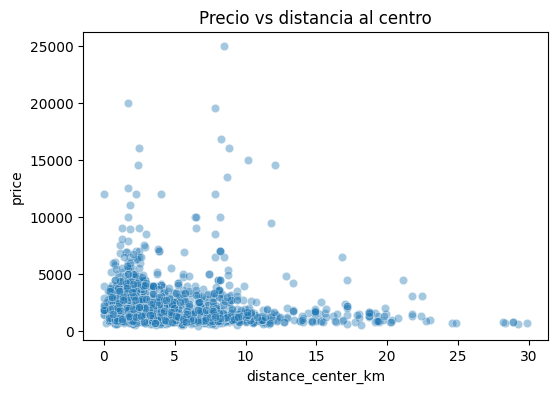

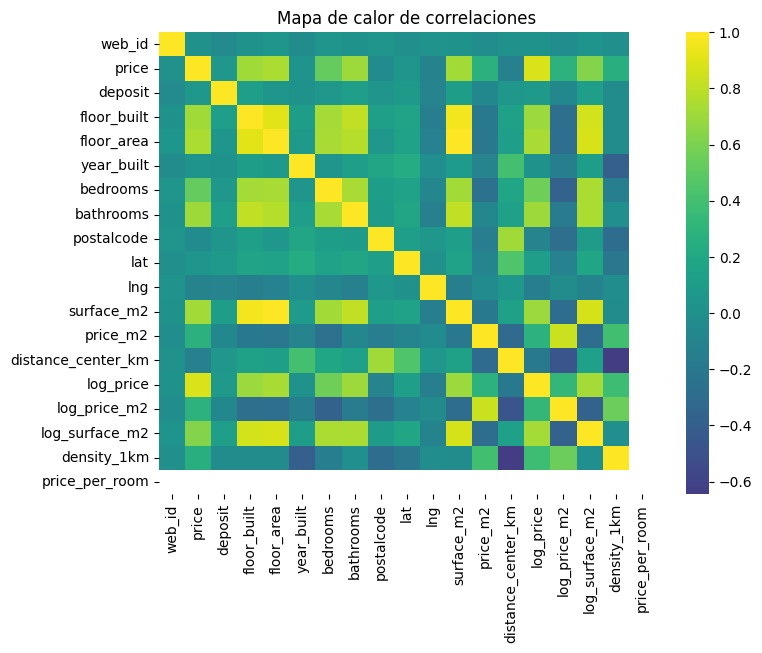

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================================
# Visualizacion 1: Precio vs distancia al centro
# =====================================================================
# Esperamos una tendencia negativa: a mayor distancia del centro,
# menor precio. La nube de puntos muestra la dispersion real.
if "distance_center_km" in rent_df.columns and "price" in rent_df.columns:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=rent_df.sample(min(2000, len(rent_df)), random_state=SEED),
        x="distance_center_km",
        y="price",
        alpha=0.4,
    )
    plt.title("Precio vs distancia al centro")
    plt.show()

# =====================================================================
# Visualizacion 2: Mapa de calor de correlaciones
# =====================================================================
# Permite ver que variables numericas estan mas relacionadas entre si
# y cuales tienen mayor correlacion con el precio (nuestra variable objetivo).
numeric = rent_df.select_dtypes(include=["number"])
if not numeric.empty:
    corr = numeric.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, cmap="viridis", center=0)
    plt.title("Mapa de calor de correlaciones")
    plt.show()


## Conclusiones del Notebook 03 — Ingenieria de Features Core

### ¿Que hemos construido?

A partir del dataset limpio, hemos creado **variables numericas derivadas** que capturan informacion geografica y de escala que el modelo necesita para predecir bien. Este paso es fundamental porque los modelos de ML no entienden "ubicacion" directamente — necesitan numeros que codifiquen esa informacion.

### Features creadas

| Feature | ¿Que representa? | ¿Por que es util? |
|---------|-------------------|-------------------|
| **`geohash_6`** | Codigo alfanumerico que agrupa pisos en cuadriculas de ~1 km | Permite calcular estadisticas por zona sin necesidad de shapefiles. Pisos con el mismo geohash estan muy cerca |
| **`h3_cell`** | Celda hexagonal H3 (resolucion 7, ~120 celdas unicas) | Similar a geohash pero con area uniforme. Mejor para clustering espacial |
| **`distance_center_km`** | Distancia en km desde el piso hasta la Puerta del Sol | Captura el efecto "centro vs periferia" que domina los precios en Madrid. Calculada con formula haversine (sobre la esfera terrestre) |
| **`log_price`, `log_surface_m2`** | Logaritmo natural de precio y superficie | Comprimen los valores extremos y hacen las distribuciones mas simetricas. Ayudan a modelos lineales a capturar relaciones no lineales |
| **`density_1km`** | Numero de anuncios en un radio de 1 km (calculado con BallTree) | Mide la "actividad del mercado" en la zona. Zonas con alta densidad suelen tener mas competencia y precios mas ajustados |
| **`price_per_room`** | Precio dividido por numero de habitaciones | Normaliza el precio por tamanio del piso. Util para comparar estudios vs pisos grandes |

### Medida anti-leakage clave: densidad OOF

La densidad local (`density_1km`) se calcula con el metodo **Out-Of-Fold (OOF)**:
- En **train**: cada piso cuenta vecinos solo del fold de entrenamiento (5-fold CV), nunca del propio fold. Asi evitamos que el piso se "vea a si mismo" en el conteo.
- En **holdout**: contamos vecinos usando todo el train (el holdout nunca se usa para calcular).

> **¿Por que importa?** Sin OOF, la densidad del piso incluiria al propio piso en el conteo, creando una relacion artificial con el target. Esto inflaria las metricas de forma irreal.

### Columnas excluidas del modelo (target-derived)

Se identificaron 4 columnas derivadas del precio que **nunca deben usarse como features**: `price_m2`, `log_price`, `log_price_m2`, `price_per_room`. Contienen informacion directa del target y usarlas seria "hacer trampa".

### Siguiente notebook
→ **NB04 (Baselines)**: Entrenar modelos simples (regresion lineal, Random Forest) para establecer un suelo de rendimiento que el boosting debera superar.